### PYSPARK MASTER CLASS
Introduction
Apache spark is a powerful open source engine that provides real-time stream processing, interactive processing, graph processing, in-memory processing as well as batch processing with very fast speed, ease of use and standard interface.

Architecture
https://jaceklaskowski.gitbooks.io/mastering-apache-spark/content/spark-architecture.html

###### Data for this example
related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit. The dataset can be downloaded from Kaggle or UCI repository:

https://archive.ics.uci.edu/ml/datasets/bank+marketing



```
IPYTHON_OPTS="notebook --no-browser --ip=172.25.152.16" pyspark --master yarn-client --num-executors 36 --driver-memory 24G --executor-memory 8G --conf spark.network.timeout=3600s --conf spark.yarn.executor.memoryOverhead=2048 --conf spark.driver.extraJavaOptions="-XX:MaxPermSize=1024m -XX:PermSize=256m" --conf spark.executor.extraJavaOptions="-XX:MaxPermSize=1024m -XX:PermSize=256m" --conf spark.ui.port="4141" --jars "/home/tzibamanzarmofrad/spark-csv_2.11-1.5.0.jar,/home/tzibamanzarmofrad/commons-csv-1.4.jar"

```
```
df = sqlContext.load(source="com.databricks.spark.csv", path="bank.csv", inferSchema=True, header=True)
```

In [1]:
from pyspark.sql import HiveContext
hive_ctx=HiveContext(sc)

In [2]:
df = hive_ctx.sql("select * from caz_dsaiml.bank_example order by rand()")

In [3]:
#df.show()
#df.printSchema()
#df.take(5)
# df.dtypes

In [4]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,58,54,35,37,33
job,unemployed,technician,blue-collar,management,technician
marital,married,married,married,married,single
education,secondary,tertiary,primary,tertiary,tertiary
default,no,no,yes,no,no
balance,610,6507,-1489,156,538
housing,yes,no,yes,no,yes
loan,no,no,yes,no,no
contact,telephone,cellular,unknown,cellular,unknown
day,29,26,29,19,29


In [5]:
df.groupBy('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [6]:
numeric_features = [feature[0] for feature in df.dtypes if feature[1] in 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215526,18,95
balance,11162,1528.5385235620856,3225.4133259461514,-6847,81204
day,11162,15.658036194230425,8.420739541006451,1,31
duration,11162,371.99381831213043,347.12838571630584,2,3881
campaign,11162,2.508421429851281,2.722077181661486,1,63
pdays,11162,51.33040673714388,108.75828197197694,-1,854
previous,11162,0.8325568894463358,2.2920072186705043,0,58


### Session2: 8 Min- Visulization and preparation

In [7]:
import seaborn as sns
%matplotlib inline
numeric_data = df.select(numeric_features).toPandas()

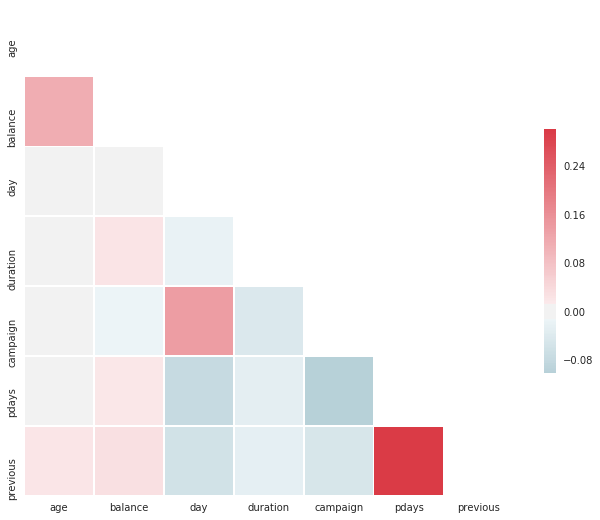

In [8]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
import numpy as np
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = numeric_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 
               'contact', 'duration', 'campaign', 'pdays', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Section 3: 10 Min Data preprocessing

In [10]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [11]:
categoricalColumns =[x[0] for x in df.dtypes if 'string' in x]
stages = list()

In [12]:
for categoricalCol in categoricalColumns:
    print (categoricalCol+"Index")
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(dropLast=False, inputCol =categoricalCol + "Index", outputCol = categoricalCol + "classVec")
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','balance', 'duration', 'campaign', 'pdays']
assemblerInputs = [categoricalCol + "classVec" for categoricalCol in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

jobIndex
maritalIndex
educationIndex
defaultIndex
housingIndex
loanIndex
contactIndex
poutcomeIndex
depositIndex


In [13]:
#stages

In [14]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df2 = df.select(selectedCols)
df = df.select(selectedCols + cols)
df2.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [15]:
pd.DataFrame(df2.take(5), columns=df2.columns).transpose()

,0,1,2,3,4
label,0,0,0,1,0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
train, test = df2.randomSplit([0.6, 0.4], seed=2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 6694
Test Dataset Count: 4468


#### section 4: 10 Min Logistic Regression
Signature: LogisticRegressionWithLBFGS.train(data, iterations=100, initialWeights=None, regParam=0.01, regType='l2', intercept=False, corrections=10, tolerance=0.0001, validateData=True, numClasses=2)
Docstring:
Train a logistic regression model on the given data.

:param data:           The training data, an RDD of
                       LabeledPoint.
:param iterations:     The number of iterations
                       (default: 100).
:param initialWeights: The initial weights (default: None).
:param regParam:       The regularizer parameter
                       (default: 0.01).
:param regType:        The type of regularizer used for
                       training our model.

                       :Allowed values:
                         - "l1" for using L1 regularization
                         - "l2" for using L2 regularization
                         - None for no regularization

                         (default: "l2")

:param intercept:      Boolean parameter which indicates the
                       use or not of the augmented representation
                       for training data (i.e. whether bias
                       features are activated or not,
                       default: False).
:param corrections:    The number of corrections used in the
                       LBFGS update (default: 10).
:param tolerance:      The convergence tolerance of iterations
                       for L-BFGS (default: 1e-4).
:param validateData:   Boolean parameter which indicates if the
                       algorithm should validate data before
                       training. (default: True)
:param numClasses:     The number of classes (i.e., outcomes) a
                       label can take in Multinomial Logistic
                       Regression (default: 2).


In [20]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [21]:
training = train.map(lambda row: LabeledPoint(row.label, row.features))
training.cache()

PythonRDD[386] at RDD at PythonRDD.scala:43

In [22]:

# Run training algorithm to build the model
model = LogisticRegressionWithLBFGS.train(training, iterations=2, regParam=0.05, regType='l2')

# Compute raw scores on the test set
predictionAndLabels = test.map(lambda lp: (float(model.predict(lp.features)), lp.label))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)


Area under PR = 0.9499338380532756
Area under ROC = 0.903828197945845


In [24]:
# Save and load model
model.save(sc, "lrModel2")
#sameModel = LogisticRegressionModel.load(sc, "lrModel")

In [85]:
#model.weights
model.numClasses

2

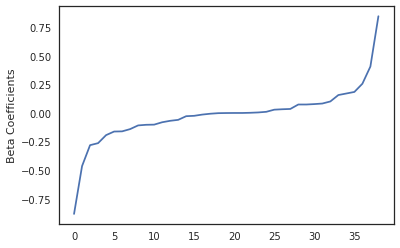

In [86]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(model.weights)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [25]:
from pyspark.ml.classification import DecisionTreeClassifier

train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

Training Dataset Count: 7838
Test Dataset Count: 3324
+---+-------------+-----+-------------+----------+-----------+
|age|          job|label|rawPrediction|prediction|probability|
+---+-------------+-----+-------------+----------+-----------+
| 37|   management|  0.0| [4122.0,0.0]|       0.0|  [1.0,0.0]|
| 30|   management|  0.0| [4122.0,0.0]|       0.0|  [1.0,0.0]|
| 21|  blue-collar|  0.0| [4122.0,0.0]|       0.0|  [1.0,0.0]|
| 31|   technician|  0.0| [4122.0,0.0]|       0.0|  [1.0,0.0]|
| 44|     services|  0.0| [4122.0,0.0]|       0.0|  [1.0,0.0]|
| 38|self-employed|  0.0| [4122.0,0.0]|       0.0|  [1.0,0.0]|
| 55|   unemployed|  0.0| [4122.0,0.0]|       0.0|  [1.0,0.0]|
| 42|   management|  1.0| [0.0,3716.0]|       1.0|  [0.0,1.0]|
| 31|   management|  1.0| [0.0,3716.0]|       1.0|  [0.0,1.0]|
| 60|  blue-collar|  1.0| [0.0,3716.0]|       1.0|  [0.0,1.0]|
+---+-------------+-----+-------------+----------+-----------+
only showing top 10 rows

